In [2]:
import numpy as np
import pandas as pd
import cvxpy as cp
import mosek
import matplotlib.pyplot as plt
import datetime as date
from datetime import datetime as dt
from dateutil.relativedelta import *
import distortion_function as hf
import phi_divergence as phi
import affine_approx as af
import Utility_functions as ut
import Cutting_plane as ct
import time
import importlib
import scipy.stats
from scipy.stats import norm, chi2, wishart, beta, lognorm
import random

In [3]:
def kl_ca_conj(x):
    return(1-np.exp(-x))

def rk_eval(X,delta, phi_conj):
    n = len(X)
    som = 0
    X = np.sort(X)
    X_diff = np.concatenate((np.array([X[0]]),np.diff(X)))
    for i in range(n):
        som = som + phi_conj(delta*(n-i)/n)*X_diff[i]
    return(som/delta)

def sd(X):
    n = len(X)
    som = 0
    m = np.mean(X)
    for i in range(n):
        som = som + (X[i]-m)**2
    return(np.sqrt(som/n))

def miniance(X):
    n = len(X)
    som = 0
    X = np.sort(X)
    X_diff = np.concatenate((np.array([X[0]]),np.diff(X)))
    for i in range(n):
        som = som + ((n-i)/n)**2*X_diff[i]
    return(som)

def h_ddro(x,delta):
    teller = 1-np.exp(-delta*x)
    noemer = 1-np.exp(-delta)
    return(teller/noemer)


def argmax_kl_dtconj(x2,x1,delta):
    frac = (np.exp(-delta*x1)-np.exp(-delta*x2))/(x2-x1)
    return(-np.log(frac/delta)/delta)

def max_kl_dtconj(x2,x1,x,delta):
    frac = (h_ddro(x2,delta)-h_ddro(x1,delta))/(x2-x1)
    return(h_ddro(x,delta)-frac*(x-x1)-h_ddro(x1,delta))

def emp_likelihood_lb(X, r):
    n = len(X)
    theta = cp.Variable()
    lbda = cp.Variable(nonneg=True)
    s = cp.Variable(n, nonneg=True)
    constraints = [s == lbda - theta + X]
    f_obj = -cp.sum(cp.kl_div(lbda, s) + lbda - s)
    obj = cp.Maximize(f_obj / n + theta - lbda * r)
    prob = cp.Problem(obj, constraints)
    prob.solve()

    return prob.value


def emp_likelihood_ub(X, r):
    n = len(X)
    theta = cp.Variable()
    lbda = cp.Variable(nonneg=True)
    s = cp.Variable(n, nonneg=True)
    constraints = [s >= 0, s == lbda + theta - X]
    f_obj = cp.sum(cp.kl_div(lbda, s) + lbda - s)
    obj = cp.Minimize(f_obj / n + theta + lbda * r)
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.MOSEK)

    return prob.value


def entropy_lb(X,r):
    n = len(X)
    theta = cp.Variable(1)
    lbda = cp.Variable(1, nonneg = True)
    t = cp.Variable(n)
    constraints = [theta-X <= -cp.kl_div(lbda,t)-lbda + t]
    #for i in range(n):
    #    constraints.append(theta - X[i] <= -cp.kl_div(lbda,t[i])-lbda + t[i])
    obj = cp.Maximize((1-r)*lbda + theta -cp.sum(t)/n)
    prob = cp.Problem(obj, constraints)
    prob.solve(solver = cp.MOSEK)
    return(prob.value)

def entropy_ub(X,r):
    n = len(X)
    theta = cp.Variable(1)
    lbda = cp.Variable(1, nonneg = True)
    t = cp.Variable(n)
    constraints = [X-theta <= -cp.kl_div(lbda,t)-lbda + t]
    #for i in range(n):
    #    constraints.append(X[i]-theta <= -cp.kl_div(lbda,t[i])-lbda + t[i])
    obj = cp.Minimize((r-1)*lbda + theta +cp.sum(t)/n)
    prob = cp.Problem(obj, constraints)
    prob.solve(solver = cp.MOSEK)
    return(prob.value)
    
    
def portfolio_ddro(R, slope, const):
    n, I = R.shape
    K = len(slope)
    a = cp.Variable(I, nonneg=True)
    beta = cp.Variable()
    lbda = cp.Variable((n, K), nonneg=True)
    v = cp.Variable(K, nonneg=True)
    p = np.ones(n) / n
    c = cp.Variable()
    expected_returns = R @ a
    constraints = [
        cp.sum(a) == 1,
        cp.abs(a) <= 1,
        expected_returns - cp.sum(lbda, axis=1) - beta <= 0,  # Vectorized
        lbda <= cp.reshape(v, (1, K))  # Ensure v is broadcasted to shape (1, K)
    ]
    
    constraints.append(beta + v @ const + p @ (lbda @ slope) <= c)
    obj = cp.Minimize(c)
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.GUROBI)
    
    return a.value, prob.value
    

def portfolio_dro(R, r):
    n, I = R.shape
    a = cp.Variable(I, nonneg=True)
    eta = cp.Variable()
    lbda = cp.Variable(nonneg=True)
    t = cp.Variable(n)
    p = np.ones(n) / n
    expected_returns = R @ a
    kl_term = -cp.kl_div(lbda, t) - lbda + t
    constraints = [
        cp.sum(a) == 1,
        cp.abs(a) <= 1,
        expected_returns - eta <= kl_term
    ]
    obj = cp.Minimize((r - 1) * lbda + eta + cp.sum(t) / n)
    prob = cp.Problem(obj, constraints)
    mosek_params2 = {
        'MSK_DPAR_INTPNT_CO_TOL_REL_GAP': 1e-7,  # Relative gap tolerance
        'MSK_DPAR_INTPNT_CO_TOL_MU_RED': 1e-7,   # Complementarity gap tolerance
        'MSK_DPAR_INTPNT_CO_TOL_PFEAS': 1e-8,    # Primal feasibility tolerance
        'MSK_DPAR_INTPNT_CO_TOL_DFEAS': 1e-8     # Dual feasibility tolerance
    }
    
    prob.solve(solver=cp.MOSEK, mosek_params=mosek_params2)
    
    return a.value, prob.value


def portfolio_dro_chi2(R,r):
    n = len(R)
    I = len(R[0])
    a = cp.Variable(I)
    eta = cp.Variable(1)
    lbda = cp.Variable(1, nonneg = True)
    t = cp.Variable(n)
    w = cp.Variable(n, nonneg = True)
    p = np.zeros(n) + 1/n
    constraints = [cp.sum(a)==1, cp.abs(a)<=1]
    for i in range(n):
        constraints.append(((R @ a)[i] - eta)/2 + lbda <= w[i])
        constraints.append(cp.norm(cp.vstack([w[i],t[i]/2]))<=(t[i]+2*lbda)/2)
    obj = cp.Minimize(r*lbda+eta+cp.sum(t)/n)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver = cp.GUROBI)
    return(a.value, prob.value)


def portfolio_saa(R):
    n = len(R)
    I = len(R[0])
    a = cp.Variable(I,nonneg = True)
    constraints = [cp.sum(a)==1, cp.abs(a)<=1]
    p = np.zeros(n) + 1/n
    obj = cp.Minimize(p@(R@a))
    prob = cp.Problem(obj,constraints)
    prob.solve(solver=cp.MOSEK)
    return(a.value, prob.value)

def portfolio_true(mu):
    I = len(mu)
    a = cp.Variable(I,nonneg = True)
    constraints = [cp.sum(a)==1, cp.abs(a)<= 1]
    obj = cp.Minimize(a@mu)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver=cp.MOSEK)
    return(a.value, prob.value)
    

    

In [4]:
def generate_samples(delta, N):
    samples = []
    for _ in range(N):
        random_number = np.random.rand()
        if random_number < delta:
            samples.append(0)  # With probability delta, append 0
        else:
            samples.append(np.random.choice([-1, 1]))  # With probability 1-delta, append -1 or 1 uniformly
    return samples


def median_saa(X):
    # Number of samples
    n = len(X)
    theta = cp.Variable()
    objective = cp.Minimize(cp.sum(cp.abs(theta - X)) / n)
    problem = cp.Problem(objective)
    problem.solve()
    return theta.value, problem.value


def median_dro(X, r):
    # Number of samples
    n = len(X)

    # Define the optimization variables
    lambda_var = cp.Variable(nonneg=True)
    theta = cp.Variable()
    eta = cp.Variable()
    t = cp.Variable(n)

    # Define the objective function
    objective = cp.Minimize(eta + lambda_var * (r - 1) + cp.sum(t) / n)

    # Define the constraints (vectorized)
    abs_diff = cp.abs(theta - X)
    kl_div_term = -cp.kl_div(t, lambda_var) - lambda_var + t
    constraints = [t >= 0, abs_diff - eta <= kl_div_term]

    # Define the problem
    problem = cp.Problem(objective, constraints)

    # Solve the problem
    problem.solve()

    # Return the optimal values
    return theta.value, problem.value

def median_ddro(R, slope, const):
    n = len(R)
    K = len(slope)
    theta = cp.Variable()
    beta = cp.Variable()
    lbda = cp.Variable((n, K), nonneg=True)
    v = cp.Variable(K, nonneg=True)
    p = np.ones(n) / n
    c = cp.Variable()
    abs_diff = cp.abs(theta - R)
    constraints = [
        abs_diff - cp.sum(lbda, axis=1) - beta <= 0,  # Vectorized
        lbda <= cp.reshape(v, (1, K))  # Ensure v is broadcasted to shape (1, K)
    ]
    
    constraints.append(beta + v @ const + p @ (lbda @ slope) <= c)
    obj = cp.Minimize(c)
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.GUROBI)
    
    return theta.value, prob.value

def ls_saa(X):
    n = len(X)
    c = cp.Variable()
    objective = cp.Minimize(cp.sum_squares(X - c) / n)
    problem = cp.Problem(objective)
    problem.solve()
    return c.value, problem.value


def ls_dro(X, r):
    n = len(X)
    lambda_var = cp.Variable(nonneg=True)
    c = cp.Variable()
    eta = cp.Variable()
    t = cp.Variable(n)
    objective = cp.Minimize(eta + lambda_var * (r - 1) + cp.sum(t) / n)
    abs_diff = (c - X)**2
    kl_div_term = -cp.kl_div(t, lambda_var) - lambda_var + t
    constraints = [t >= 0, abs_diff - eta <= kl_div_term]

    problem = cp.Problem(objective, constraints)
    problem.solve()

    return c.value, problem.value


In [5]:
def generate_samples(delta_gen, n_samples):
    # Generate random numbers between 0 and 1
    random_values = np.random.rand(n_samples)
    
    # Initialize the samples array
    samples = np.zeros(n_samples)
    
    # Assign 0 where random value is less than delta_gen
    samples[random_values >= delta_gen] = np.random.choice([-1, 1], size=(random_values >= delta_gen).sum())
    
    return samples

def generate_samples2(N, delta_gen, epsilon_gen, M):
    # generate samples X = X1 + Z
    X_samples = np.zeros(N)
    
    # Generate samples for X1
    # X1 = 0 with probability delta_gen, and with probability (1 - delta_gen), X1 = 1 or -1
    X1_samples = np.where(np.random.rand(N) < delta_gen, 
                          0, 
                          np.random.choice([-1, 1], size=N))
    
    # Generate samples for Z
    # Z = 0 with probability (1 - epsilon_gen), and Z = M with probability epsilon_gen
    Z_samples = np.where(np.random.rand(N) < epsilon_gen, 
                         M, 
                         0)
    
    # Compute X = X1 + Z
    X_samples = X1_samples + Z_samples
    
    return X_samples



3.9
3.6898851898392167 1.154976446346639
1.7885034832696602 0.6668071339024895


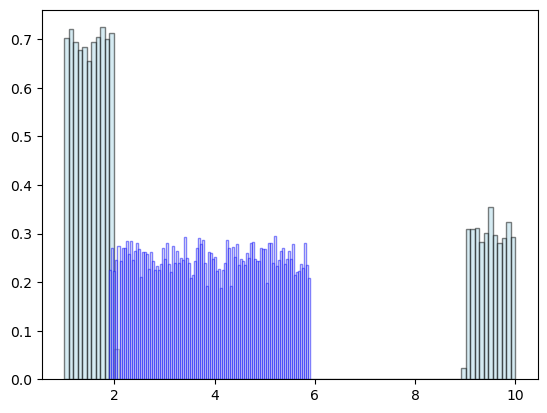

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
n_samples = 10000
a1, b1 = 1,2
dt = 0.3
M = 
X1 = np.random.uniform(a1,b1,size = n_samples) + np.random.binomial(1,dt,size = n_samples)*M
m1 = 0.5*(a1+b1)+ dt*M
X2 = np.random.uniform(m1-2,m1+2,size = n_samples)
plt.hist(X1, bins=100, density=True, alpha=0.5, color='lightblue', edgecolor='black', label=f'Sample X')
plt.hist(X2, bins=100, density=True, alpha=0.5, color='lightyellow', edgecolor='blue', label=f'Sample Y')
#plt.xlim(0, 25)
print(m1)
print(sd(X1),sd(X2))
print(np.mean(X1)-miniance(X1), np.mean(X2)-miniance(X2))

In [76]:
# Robust median estimation
M = 300
eps_gen = 0.009  # Set epsilon to your desired value
delta_gen = 0.01  # Set delta to your desired value
N = 1000  # Number of samples to generate
eps = 0.0001
rep = 100
saa_count = 0
dro_count = 0
ddro_count = 0
np.random.seed(250)
for i in range(rep):
    #samples = generate_samples(delta_gen,N)
    samples = generate_samples2(N, delta_gen, eps_gen, M)
    r = chi2.ppf(0.999,1)/(2*N)
    r2 = np.sqrt(2*chi2.ppf(0.999,1))
    delta = r2/np.sqrt(N)
    x_points = af.affine_approx(eps,argmax_kl_dtconj,max_kl_dtconj,delta)
    if len(x_points)==2:
        print('true')
    else:
        [slope, const] = af.makepoints(h_ddro,x_points,delta)
    sol_saa = median_saa(samples)[0]
    sol_dro = median_dro(samples,r)[0]
    sol_ddro = median_ddro(samples, slope, const)[0]
    if np.abs(sol_saa) <= 0.01:
        saa_count = saa_count + 1
    if np.abs(sol_dro) <= 0.01:
        dro_count = dro_count + 1
    if np.abs(sol_ddro) <= 0.01:
        ddro_count = ddro_count + 1
    if i% 50 == 0:
        print(i)
    

6.6348966010212145

In [84]:
print(np.mean(saa_count))
print(np.mean(dro_count))
print(np.mean(ddro_count))

22.0
22.0
84.0


In [65]:
(1-eps_gen)*(0.5+0.5*delta_gen)

0.500455

In [205]:
#### portfolio problem

n_size =np.array([1000])
#n_size =np.array([40,100,200,600,1000,2000,5000,10000])
x_dro = []
x_ddro = []
x_saa = []
rep = 1
eps = 0.0001

for i in range(len(n_size)):
    for j in range(rep):
        if j % 50 == 0 :
            print(i,j)
        X = np.random.lognormal(0,2,size = n_size[i])
        Y= np.random.normal(np.exp(2**2/2)+0.05, 17,size = n_size[i])
        R = np.array([X,Y]).T
        r = chi2.ppf(0.95,1)/(2*n_size[i])
        r2 = np.sqrt(2*chi2.ppf(0.95,1))
        delta = r2/np.sqrt(n_size[i])
        x_points = af.affine_approx(eps,argmax_kl_dtconj,max_kl_dtconj,delta)
        if len(x_points)==2:
            print('true')
        else:
            [slope, const] = af.makepoints(h_ddro,x_points,delta)
        sol_dro = portfolio_dro(R, r)
        sol_ddro = portfolio_ddro(R, slope, const)
        sol_saa = portfolio_saa(R)
        x_dro.append(sol_dro)
        x_ddro.append(sol_ddro)
        x_saa.append(sol_saa)

print(sol_dro, sol_ddro, sol_saa)

0 0
(array([0.2241559, 0.7758441]), 8.18196753514124) (array([0.61841334, 0.38158666]), 7.595926713587376) (array([0., 1.]), 7.247955940532289)


In [6]:

def inventory_ddro(R, b, h, slope, const):
    n, I = R.shape
    K = len(slope)
    a = cp.Variable(I)
    beta = cp.Variable()
    lbda = cp.Variable((n, K), nonneg=True)
    v = cp.Variable(K, nonneg=True)
    p = np.ones(n) / n
    c = cp.Variable()
    pos_a_minus_R = cp.pos(cp.vstack([a] * n) - R)  # Elementwise positive part of (a - R)
    pos_R_minus_a = cp.pos(R - cp.vstack([a] * n))  # Elementwise positive part of (R - a)
    f_obj_vector = b @ pos_a_minus_R.T + h @ pos_R_minus_a.T  # Shape (n,)
    constraints = [
        f_obj_vector - cp.sum(lbda, axis=1) - beta <= 0,  # Vectorized constraints
        lbda <= cp.reshape(v, (1, K)),  # Ensure v is broadcasted to shape (1, K)
        beta + v @ const + p @ (lbda @ slope) <= c
    ]
    obj = cp.Minimize(c)
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.GUROBI)
    
    return a.value, prob.value

def inventory_dro(R, b, h, r):
    n, I = R.shape
    a = cp.Variable(I)
    eta = cp.Variable()
    lbda = cp.Variable(nonneg=True)
    t = cp.Variable(n)
    a_expanded = cp.reshape(a, (1, I))  # Shape (1, I)
    a_expanded = cp.vstack([a_expanded] * n)  # Shape (n, I)
    pos_a_minus_R = cp.pos(a_expanded - R)  # Elementwise positive part of (a - R)
    pos_R_minus_a = cp.pos(R - a_expanded)  # Elementwise positive part of (R - a)
    kl_term = -cp.kl_div(lbda, t) - lbda + t
    lhs = b @ pos_a_minus_R.T + h @ pos_R_minus_a.T - eta
    constraints = [lhs <= kl_term]
    objective = cp.Minimize((r - 1) * lbda + eta + cp.sum(t) / n)
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.MOSEK)

    return a.value, prob.value


def inventory_SAA(R, b, h):
    n, I = R.shape
    a = cp.Variable(I)
    a_expanded = cp.reshape(a, (1, I))  # Shape (1, I)
    a_expanded = cp.vstack([a_expanded] * n)  # Shape (n, I)
    pos_a_minus_R = cp.pos(a_expanded - R)  # Elementwise positive part of (a - R)
    pos_R_minus_a = cp.pos(R - a_expanded)  # Elementwise positive part of (R - a)
    f_obj_vector = b @ pos_a_minus_R.T + h @ pos_R_minus_a.T  # Shape (n,)
    f_obj = cp.sum(f_obj_vector) / n
    obj = cp.Minimize(f_obj)
    prob = cp.Problem(obj)
    prob.solve(solver=cp.GUROBI)
    
    return a.value, prob.value
    

def inventory_obj(R,w,b,h):
    n = len(R)
    f_obj = np.zeros(n)
    for i in range(n):
        f_obj[i] = b.dot(np.maximum(w-R[i],0))+h.dot(np.maximum(R[i]-w,0)) 
    return(f_obj)

In [7]:
def cvar_SAA(alpha, R):
    n = len(R)
    theta_1 = cp.Variable()
    t = cp.Variable(n)
    obj = cp.Minimize(theta_1 + (1 / n) * (1 / (1 - alpha)) * cp.sum(cp.pos(R - theta_1)))
    prob = cp.Problem(obj)
    prob.solve(solver=cp.MOSEK)

    return theta_1.value, prob.value

def cvar_DRO(alpha, R, r):
    n = len(R)
    theta_1 = cp.Variable()
    theta_2 = cp.Variable()
    lbda = cp.Variable(nonneg=True)
    t = cp.Variable(n)
    p = np.ones(n) / n
    R_minus_theta_2 = R - theta_2
    constraints = [
        cp.pos(1 / (1 - alpha) * (R_minus_theta_2)) - theta_1 <= -cp.kl_div(lbda, t) - lbda + t
    ]
    obj = cp.Minimize(theta_1 + theta_2 + lbda * (r - 1) + p @ t)
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.MOSEK)

    return theta_1.value, theta_2.value, lbda.value, prob.value


def cvar_ddro(R, alpha, slope, const):
    n = len(R)
    K = len(slope)
    # Variables
    x = cp.Variable(1)
    beta = cp.Variable(1)
    lbda = cp.Variable((n, K), nonneg=True)
    v = cp.Variable(K, nonneg=True)
    p = np.ones(n) / n
    c = cp.Variable(1)

    # Constraints
    constraints = [
        x + 1/(1-alpha) * cp.pos(R - x) - cp.sum(lbda, axis=1) - beta <= 0,
        lbda <= cp.vstack([v]*n),  # Vectorized lbda[i, j] <= v[j] for each i
        beta + v @ const + p @ (lbda @ slope) <= c
    ]

    # Objective
    obj = cp.Minimize(c)
    
    # Define and solve the problem
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.GUROBI)

    # Return the optimal value of x and the optimal objective value
    return x.value, prob.value

def cvar_pareto(alpha,m,p):
    return(m*p/((1-alpha)**(1/p)*(p-1)))

def cvar_exponential(alpha,lbda):
    return((-np.log(1-alpha)+1)/lbda)

def cvar_obj(R,x,alpha):
    return(x+1/(1-alpha)*np.maximum(R-x,0))

In [87]:
mu = 0.5
sig = 0.87
ld = np.exp(mu+sig**2/2)
A = np.random.lognormal(mu,sig,size = 10000)
B = np.random.exponential(ld,size = 10000)
print(np.mean(A),np.mean(B))
print(sd(A),sd(B))
print(np.mean(A)-miniance(A), np.mean(B)-miniance(B))

2.3813260980348137 2.406315721955135
2.490233761026887 2.410963457631338
1.0994243123960699 1.201241161896215


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Sample mean of X: 7.306311892509372
Sample mean of Z: 7.376145339537565
Sample sd of X: 5.5829488556278095
Sample sd of Z: 2.8488949459102137
0.025542088537459144


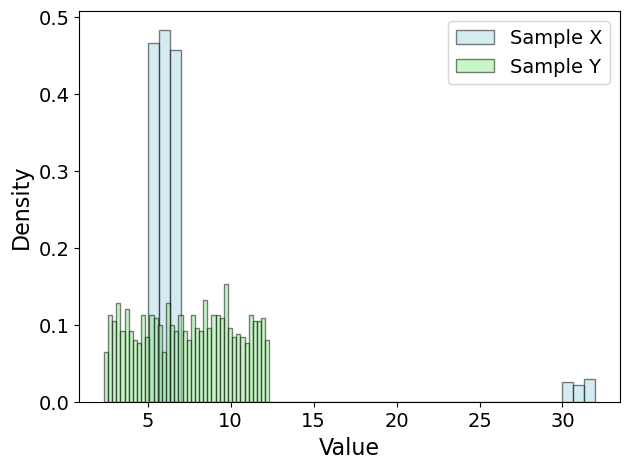

In [402]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform

a_x, b_x = 5, 7  # Range for uniform part of Z
M = 25           # Constant value for Z
epsilon = 0.05    # Probability of taking value M
mean_x = (a_x+b_x)/2 +epsilon*M
a_z, b_z = (mean_x+0.1)-5, (mean_x+0.1)+5
# Generate samples
n_samples = 1000
X = np.random.uniform(a_x,b_x,size = n_samples)+np.random.binomial(1,epsilon,size = n_samples)*M

# Generate samples from Z (mixture distribution)
Z = np.random.uniform(a_z,b_z,size = n_samples) 

# Plot histograms
#plt.figure(figsize=(12, 6))

# Histogram for X
plt.hist(X, bins=40, density=True, alpha=0.5, color='lightblue', edgecolor='black', label=f'Sample X')

# Histogram for Z
plt.hist(Z, bins=40, density=True, alpha=0.5, color='lightgreen', edgecolor='black', label=f'Sample Y')

# Add title and labels
#plt.title("Histograms of Uniform Distribution X and Mixture Distribution Z")
plt.xlabel("Value", fontsize = 16)
plt.ylabel("Density", fontsize = 16)
plt.xticks(fontsize=14)  # Set font size for x-axis tick labels
plt.yticks(fontsize=14)
plt.legend(fontsize = 14)
plt.tight_layout()
plt.savefig('dro_xy_dist.eps', format = 'eps')

# Output sample statistics
print(f"Sample mean of X: {np.mean(X)}")
print(f"Sample mean of Z: {np.mean(Z)}")
print(f"Sample sd of X: {np.sqrt(np.var(X))}")
print(f"Sample sd of Z: {np.sqrt(np.var(Z))}")
print((np.mean(Z)-np.mean(X))/(np.sqrt(np.var(X))-np.sqrt(np.var(Z))))


In [405]:
print(a_z,b_z)

2.3499999999999996 12.35


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


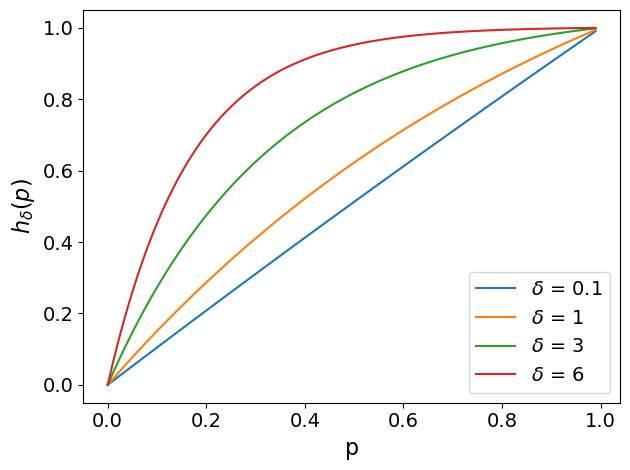

In [417]:
x = np.arange(0, 1, 1/100)
for delta in [0.1, 1, 3, 6]:
    h_value = kl_ca_conj(x * delta) / kl_ca_conj(delta)
    plt.plot(x, h_value, label=fr'$\delta$ = {delta}')  # Add legend for each delta

# Add legend and labels
plt.xlabel("p", fontsize = 16)
plt.ylabel(r"$h_{\delta}(p)$", fontsize = 16)
plt.xticks(fontsize=14)  # Set font size for x-axis tick labels
plt.yticks(fontsize=14)
plt.legend(fontsize = 14)
plt.tight_layout()
plt.savefig('ddro_distortion.eps', format = 'eps')

In [262]:
print(0.5*(b_z+a_z))
print(0.5*(b_x+a_x)+M*epsilon)
print(np.sqrt(1/12)*(b_x-a_x)+np.sqrt(epsilon*M**2-epsilon**2*M**2))
print(np.sqrt(1/12)*(b_z-a_z))

7.050000000000001
7.0
4.936249212730299
2.309401076758503


In [403]:
print(np.mean(X)-miniance(X))
print(np.mean(Z)-miniance(Z))

1.529884421393671
1.644405952507471


In [406]:
np.sum(X-Z<=0)/1000

0.609

In [142]:
print((a_x+b_x)/2)
print((a_z+b_z)/2 +epsilon*M)

6.85
6.75


In [13]:
np.random.seed(1)

b = np.random.exponential(20,size=2)
h = np.random.exponential(20,size=2)  
scale = np.eye(3)  
sigma_d = wishart.rvs(3, scale, size=1)


In [7]:
print(sigma_d)
print(b)
print(h)

[[ 0.05674871 -0.12582101 -0.25560246]
 [-0.12582101  2.59072482  1.88251825]
 [-0.25560246  1.88251825  1.98379347]]
[1.07921167e+01 2.54825051e+01 2.28762717e-03]
[7.2002551  3.1741919  1.93767743]


In [8]:
np.random.seed(683)

In [78]:
np.diag(sigma_d)

array([0.05674871, 2.59072482, 1.98379347])

In [69]:
R = np.random.multivariate_normal(np.zeros(3),sigma_d,size = 2000)

In [74]:
[w_saa, obj_saa]= inventory_SAA(R,b,h)

In [71]:
np.mean(inventory_obj(R,w_true,b,h))

12.311019233103078

In [72]:
w_true

array([-0.25287148, -1.22246378,  3.04093837])

In [323]:
s_size = int(N_size/2)
R1 = R[0:s_size]
R2 = R[s_size:int(len(R))]    
[w_emp, emp_obj]= inventory_SAA(R1,b,h)
l_sample = inventory_obj(R,w_emp,b,h)
r = (2*norm.ppf(0.95)*sd(l_sample)/(np.mean(l_sample)-miniance(l_sample)))
eps = 0.0001
delta = r/np.sqrt(len(R))
x_points = af.affine_approx(eps,argmax_kl_dtconj,max_kl_dtconj,delta)
[slope, const] = af.makepoints(h_ddro,x_points,delta)


In [29]:
n = 1000
X = np.random.lognormal(0,2,size = n)
Y= np.random.normal(np.exp(2**2/2)+0.05, 20,size = n)
R = np.array([X,Y]).T
r = chi2.ppf(0.95,1)/(2*n)
r2 = np.sqrt(2*chi2.ppf(0.95,1))
delta = r2/np.sqrt(n)
eps = 0.0001
x_points = af.affine_approx(eps,argmax_kl_dtconj,max_kl_dtconj,delta)
if len(x_points)==2:
    print('true')
else:
    [slope, const] = af.makepoints(h_ddro,x_points,delta)
    sol_dro = inventory_dro(R, b, h, r)
    sol_ddro = inventory_ddro(R, b, h, slope, const)
    sol_saa = inventory_SAA(R, b, h)
n_test = 10000
X_t = np.random.lognormal(0,2,size = n_test)
Y_t= np.random.normal(np.exp(2**2/2)+0.05, 20,size = n_test)
R_t = np.array([X_t,Y_t]).T
print(np.mean(inventory_obj(R_t,sol_dro[0],b,h)))
print(np.mean(inventory_obj(R_t,sol_ddro[0],b,h)))
print(np.mean(inventory_obj(R_t,sol_saa[0],b,h)))

194.18031166762958
194.02142824811364
193.92950129594718


In [22]:
##### Newsvendor
N_size = 2000
lb = np.zeros(1000)
lb2 = np.zeros(len(lb))
SAA = np.zeros(len(lb))
ub = np.zeros(len(lb))
ub_d = np.zeros(len(lb))
for i in range(len(lb)):
    R = np.random.multivariate_normal(np.zeros(3),sigma_d,size = N_size)
    s_size = int(N_size/2)
    R1 = R[0:s_size]
    R2 = R[s_size:int(len(R))]    
    [w_emp, emp_obj]= inventory_SAA(R1,b,h)
    l_sample = inventory_obj(R1,w_emp,b,h)
    r = (2*norm.ppf(0.95)*sd(l_sample)/(np.mean(l_sample)-miniance(l_sample)))
    r_l = (2*norm.ppf(0.95)*sd(l_sample)/(miniance(l_sample)))
    eps = 0.0001
    delta = r/np.sqrt(len(R))
    delta_l = r_l/np.sqrt(len(R))
    x_points = af.affine_approx(eps,argmax_kl_dtconj,max_kl_dtconj,delta)
    if len(x_points)==2:
        print('true')
        [w_emp2, emp_obj2] = inventory_SAA(R,b,h)
        lb[i] = ((1-np.exp(-delta))/delta *emp_obj2)
    else:
        [slope, const] = af.makepoints(h_ddro,x_points,delta)
        [sol, ub_d[i]] = inventory_ddro(R,b,h,slope,const)
        [slope2, const2] = af.makepoints(h_ddro,x_points,delta_l)
        [sol_l,lb_val] = inventory_ddro(R,b,h,slope2,const2)
        lb[i] = (1-np.exp(-delta_l))/delta_l *lb_val
        
    delta2 = (norm.ppf(0.95)**2)/(2*len(R))
    [sol2,ub_val] = inventory_dro(R,b,h,delta2)
    ub[i] = ub_val
    [w_emp2, emp_obj2] = inventory_SAA(R,b,h)
    SAA[i] = emp_obj2
    l_sample2 = inventory_obj(R,w_emp2,b,h)
    lb2[i] = entropy_lb(l_sample2,delta2)
    if i % 10 == 0:
        print(i)
    
    

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [12]:
np.random.seed(20)
np.random.seed(10)
q1 = h[0]/(b[0]+h[0])
q2 = h[1]/(b[1]+h[1])
q3 = h[2]/(b[2]+h[2])
sigma_1,sigma_2,sigma_3 =np.diag(sigma_d) 
w_true = np.array([norm.ppf(q1)*np.sqrt(sigma_1),norm.ppf(q2)*np.sqrt(sigma_2),norm.ppf(q3)*np.sqrt(sigma_3)])
R0 = np.random.multivariate_normal(np.zeros(3),sigma_d,size = 1000000)
obj_samp = inventory_obj(R0,w_true,b,h)
obj_true = np.mean(obj_samp)
obj_true

10.377498004275832

In [23]:
print(np.sum(lb<=obj_true)/len(lb))
print(np.sum(lb2<=obj_true)/len(lb2))
print(np.sum(ub>=obj_true)/len(ub))
print(np.sum(ub_d>=obj_true)/len(ub_d))


0.95
0.951
0.957
0.956


In [24]:
#data_news = {'ub_d_40':ub_d, 'ub_40': ub, 'lb_20':lb, 'lb2_20': lb2}
#df_news = pd.DataFrame(data = data_news)

In [24]:
df_news['ub_d_2000'] = ub_d
df_news['ub_2000'] = ub
df_news['lb_2000'] = lb
df_news['lb2_2000'] = lb2

In [25]:
df_news

,ub_d_20,ub_20,lb_20,lb2_20,ub_d_40,ub_40,lb_40,lb2_40,ub_d_60,ub_60,...,lb_800,lb2_800,ub_d_1000,ub_1000,lb_1000,lb2_1000,ub_d_2000,ub_2000,lb_2000,lb2_2000
0,8.802908,8.819064,5.159130,5.326943,11.242619,11.189721,7.802819,8.522374,10.683290,10.710571,...,9.515068,9.524277,10.853604,10.849703,10.008708,10.022611,10.864146,10.876641,10.264284,10.248808
1,12.809501,12.479384,6.003642,7.433646,12.785824,12.716538,9.538288,9.584107,14.047653,14.363196,...,10.142861,10.125584,10.671672,10.694221,9.884915,9.868241,10.810464,10.824987,10.241747,10.234272
2,16.210423,15.368654,2.634108,5.939367,14.500976,14.695810,8.867201,7.959420,11.373460,11.970486,...,9.785621,9.762398,10.626887,10.677312,9.874971,9.810284,11.167514,11.182496,10.548461,10.549381
3,10.028637,10.052455,6.247650,6.566780,12.228119,12.741630,8.992983,8.704401,11.157517,11.232437,...,9.906680,9.839309,10.589669,10.593078,9.758036,9.781238,10.620579,10.653217,10.073118,10.034765
4,9.773355,9.809773,6.533951,6.086182,10.435242,10.357892,7.489895,7.540735,12.720006,12.788630,...,9.614950,9.613514,11.111865,11.146851,10.339723,10.308342,10.502294,10.506230,9.893312,9.891104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,9.722566,9.755098,6.945938,6.881606,10.365022,10.380624,7.893971,7.972730,14.704318,14.190322,...,10.190907,10.165894,10.966990,10.965333,10.073437,10.086297,10.610239,10.630705,10.056719,10.024214
996,8.536760,8.621150,5.897222,5.613861,13.483491,14.146253,7.141062,7.563865,12.328124,12.185844,...,9.637008,9.813892,10.867265,10.921543,10.089969,10.043637,10.639298,10.654739,10.033837,10.023236
997,9.073492,9.117091,5.794799,5.576578,12.077399,12.092385,8.989708,9.512314,10.618825,10.507303,...,9.908512,9.888311,11.078908,11.080086,10.248304,10.263824,10.829823,10.831982,10.271170,10.257702
998,13.379122,13.467465,9.494092,9.545429,14.876263,16.429472,10.873488,8.739594,11.789008,12.086468,...,9.926280,9.922954,10.696759,10.694952,9.674589,9.711357,10.399313,10.404092,9.832275,9.841282


In [26]:
df_news.to_csv('dual_DRO_news2.csv', index=False)

In [9]:
df_news = pd.read_csv('dual_DRO_news2.csv')

In [19]:
np.random.seed(1)
R = np.random.multivariate_normal(mu_vec,sigma_d,size = 10000)
obj = 0
for i in range(len(R)):
    obj = obj + b[0]*np.maximum(norm.ppf(0.8/(1.8))-R[i][0],0)+h[0]*np.maximum(R[i][0]-norm.ppf(0.8/(1.8)),0)
print(obj/len(R))

0.708497282518393


In [79]:
np.random.seed(105)

In [135]:
##### CVaR
N_size = 800
alpha = 0.95
M_size = 1000
SAA = np.zeros(M_size)
ub = np.zeros(M_size)
ub_d = np.zeros(M_size)
x_dro = []
x_ddro = []
for i in range(M_size):
    #R = np.random.exponential(10,size = N_size)
    R = (np.random.pareto(3,N_size)+1)*2
    s_size = int(N_size/2)
    R1 = R[0:s_size]
    R2 = R[s_size:int(len(R))]    
    [w_emp, emp_obj]= cvar_SAA(alpha,R1)
    l_sample = cvar_obj(R2,w_emp,alpha)
    while sd(l_sample) == 0:
        print('while')
        #R2 = np.random.exponential(10,size = N_size)
        R2 = (np.random.pareto(3,int(N_size/2))+1)*2
        l_sample = cvar_obj(R2,w_emp,alpha)
    r = (2*norm.ppf(0.95)*sd(l_sample)/(np.mean(l_sample)-miniance(l_sample)))
    eps = 0.0001
    delta = r/np.sqrt(len(R))
    x_points = af.affine_approx(eps,argmax_kl_dtconj,max_kl_dtconj,delta)
    if len(x_points)==2:
        print('true')
        eps = 0.00001
        x_points = af.affine_approx(eps,argmax_kl_dtconj,max_kl_dtconj,delta)
    [slope, const] = af.makepoints(h_ddro,x_points,delta)
    [sol, ub_d[i]] = cvar_ddro(R,alpha,slope,const)
    x_ddro.append(sol)
        
    delta2 = (norm.ppf(0.95)**2)/(2*len(R))
    [t_1, t_2, ld_v, ub[i]] = cvar_DRO(alpha, R, delta2)
    x_dro.append(np.array([t_1,t_2,ld_v]))
    #[w_emp2, emp_obj2] = cvar_SAA(alpha,R)
    #SAA[i] = emp_obj2
    #l_sample2 = inventory_obj(R,w_emp2,b,h)
    #lb2[i] = entropy_lb(l_sample2,delta2)
    if i % 10 == 0:
        print(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [119]:
T_test = (np.random.pareto(3,100000)+1)*2
obj1 = np.zeros(10)
obj2 = np.zeros(10)
for i in range(10):
    obj1[i] = np.mean(cvar_obj(T_test,x_ddro[i],alpha))
    obj2[i] = np.mean(cvar_obj(T_test,x_dro[i][1],alpha))

In [120]:
print(obj1)
print(obj2)

[8.34431482 8.12934917 8.11528948 8.25560289 8.44489165 8.14925216
 8.33694745 8.23235286 8.54211443 8.1122488 ]
[8.2214276  8.12687986 8.12455218 8.24203333 8.25691459 8.12419171
 8.2060948  8.11964033 8.28803522 8.11488106]


In [121]:
obj_true

8.143252849784718

In [136]:
obj_true = cvar_pareto(alpha,2,3)
#obj_true = cvar_exponential(alpha,1/10)
print(np.sum(ub>=obj_true)/len(ub))
print(np.sum(ub_d>=obj_true)/len(ub_d))
print(np.median(ub))
print(np.median(ub_d))

0.867
0.83
9.197867884598963
9.028647910650399


In [137]:
df_cvar_pare['ub_800'] = ub
df_cvar_pare['ub_d_800'] = ub_d

In [138]:
df_cvar_pare

,ub_200,ub_d_200,ub_400,ub_d_400,ub_600,ub_d_600,ub_800,ub_d_800
0,9.788695,10.037805,7.850745,7.596636,10.115659,9.429952,9.622218,9.488324
1,7.126231,6.688796,8.399426,8.161929,7.945687,8.115831,13.551577,13.728064
2,8.682368,8.026337,11.251208,11.036279,9.590335,9.419614,9.511222,9.348871
3,12.163519,12.031079,8.828066,8.727342,8.354046,8.125778,8.376744,8.306745
4,8.729196,8.068599,7.879503,7.708439,8.191647,8.295119,8.972979,8.868976
...,...,...,...,...,...,...,...,...
995,8.107609,7.846804,8.587734,8.097080,7.990845,7.955458,9.041671,9.047435
996,16.412342,16.708792,9.833945,10.645495,7.851929,7.449520,9.112305,8.760351
997,8.361001,8.253227,9.611207,9.476259,9.740632,9.351012,7.939113,7.783084
998,6.921076,6.887725,7.785863,7.614619,10.882755,10.525514,8.760360,8.619469


In [104]:
#data_cvar_pare = {'ub_200': ub, 'ub_d_200': ub_d}
#df_cvar_pare = pd.DataFrame(data = data_cvar_pare)

In [139]:
df_cvar_pare.to_csv('dual_DRO_cvar_pare3.csv', index=False)

In [27]:
ub

array([ 57.3077039 ,  90.94826117,  52.60214232,  55.86682518,
        57.06491804,  40.33019966,  51.21323235,  63.69506305,
        89.79835105,  41.49259999,  82.70106351,  77.14955532,
        55.29936748,  57.35182269,  69.56002003,  66.72412394,
        59.60329369,  57.57701344,  48.87299906,  58.44672446,
        47.15642457,  45.30172731,  49.19910873,  56.55692155,
        68.83624619,  61.60299466,  54.35251386,  59.32103809,
        65.59810938,  45.41447734,  54.04199155,  66.76731548,
        47.70566951,  55.93867319,  76.60446186,  71.57100903,
        64.44587124,  81.31874354,  61.11243577,  60.87729798,
        57.99656647,  59.82315375,  48.6442397 ,  42.81571975,
        68.46353036,  50.60162602,  76.01279004,  48.81058752,
        52.21902794,  59.6926015 ,  65.949375  ,  51.20882047,
        51.14550188,  51.69746369,  60.59213258,  54.5725976 ,
        62.93868029,  67.70300539,  50.48991776,  51.22664916,
       116.54366573,  53.13619906,  43.13655566,  47.92

In [260]:
n_cv = 300
alpha = 0.95
R_cv = (np.random.pareto(5,n_cv)+1)*2
s_size = int(n_cv/2)
R1 = R_cv[0:s_size]
R2 = R_cv[s_size:int(len(R_cv))]    
[w_emp, emp_obj]= cvar_SAA(alpha,R1)
l_sample = cvar_obj(R2,w_emp,alpha)
while sd(l_sample) == 0:
    R2 = (np.random.pareto(5,n_cv/2)+1)*2
    l_sample = cvar_obj(R2,w_emp,alpha)
r = (2*norm.ppf(0.95)*sd(l_sample)/(np.mean(l_sample)-miniance(l_sample)))
eps = 0.0001
delta = r/np.sqrt(len(R_cv))
x_points = af.affine_approx(eps,argmax_kl_dtconj,max_kl_dtconj,delta)
[slope, const] = af.makepoints(h_ddro,x_points,delta)
print(cvar_ddro(R_cv,alpha,slope,const))
delta2 = norm.ppf(0.95)**2/(2*len(R_cv))
print(kl_cvar_ball(alpha,R_cv,delta2))



(array([4.53304191]), 5.684043286360783)
(array([1.38447935]), array([3.92276487]), array([96.23556377]), 5.74045696718899)


In [236]:
w_emp+1/(1-alpha)*np.maximum(R_cv-w_emp,0)

array([  7.15127255,   7.15127255,   7.15127255,   7.15127255,
         7.15127255,   7.15127255,   7.15127255,   7.15127255,
         7.15127255,   7.15127255,   7.15127255,   7.15127255,
         7.15127255,   7.15127255,   7.15127255, 218.19048441,
         7.15127255,   7.15127255,   7.15127255,   7.15127255,
         7.15127255,   7.15127255,   7.15127255,   7.15127255,
         7.15127255,   7.15127255,   7.15127255,   7.15127255,
         7.15127255,   7.15127255,   7.15127255,   7.15127255,
         7.15127255,   7.15127255,   7.15127255,   7.15127255,
         7.15127255,   7.15127255,   7.15127255,   7.15127255,
         7.15127255,   7.15127255,   7.15127255, 258.05460211,
         7.15127255,   7.15127255,   7.15127255,   7.15127255,
         7.15127255,   7.15127255,   7.15127255,   7.15127255,
         7.15127255,   7.15127255,   7.15127255,   7.15127255,
         7.15127255,   7.15127255,   7.15127255,   7.15127255,
         7.15127255,   7.15127255,   7.15127255,   7.15

In [889]:
print((a_x+b_x)/2)
print(p*((b_y+a_y)*0.5)+(1-p)*np.mean(outliers)+translation)

15.0
3.693333333333335


In [811]:
r_p = norm.ppf(0.95)**2/(2*len(X)) 
print(entropy_ub(X,r_p))
print(entropy_ub(Z2,r_p))

26.30896007441561
27.18615330890418


In [812]:
if np.mean(X)< np.mean(Z2):
    r1 = (2*norm.ppf(0.95)*sd(X)/(np.mean(X)-miniance(X)))
else:
    r1 = (2*norm.ppf(0.95)*sd(Z2)/(np.mean(Z2)-miniance(Z2)))
delta = r1/np.sqrt(len(X))
print(rk_eval(X,delta, kl_ca_conj)*delta/kl_ca_conj(delta))
print(rk_eval(Z2,delta, kl_ca_conj)*delta/kl_ca_conj(delta))

26.3086602835373
26.071507958506285


In [625]:
b=4
p = 3.1
print(1/np.sqrt(12)*b, 2*np.sqrt(p)/((p-1)*(np.sqrt(p-2))))
print(b/6,2*p/((p-1)*(2*p-1)))

1.1547005383792517 1.5988039231705096
0.6666666666666666 0.5677655677655677


In [591]:
def maxiance_pareto(xm,p):
    return(xm*(p/((p-1)*(2*p-1))))

def maxiance_uniform(a,b):
    return((b-a)/6)

maxiance_pareto(3,3)

0.8999999999999999

In [26]:
#n_size =np.array([200])
n_size =np.array([40,100,200,600,1000,2000,5000,10000])
#n_size =np.array([40,80,100,200,400,600,800,1000,2000,4000,8000,10000])
x_dro = np.zeros(len(n_size))
x_ddro = np.zeros(len(n_size))
x_SAA = np.zeros(len(n_size))
rep = 500
a_x, b_x = 5, 7  # Range for uniform part of Z
M = 20           # Constant value for Z
noise_eps = 0.05    # Probability of taking value M
mean_x = (a_x+b_x)/2 +noise_eps*M
a_y, b_y = (mean_x+0.1)-5, (mean_x+0.1)+5

for i in range(len(n_size)):
    x_tel1 = 0
    x_tel2 = 0
    x_tel3 = 0
    for j in range(rep):
        if j % 50 == 0 :
            print(i,j)
        X = np.random.uniform(a_x,b_x,size = n_size[i])+np.random.binomial(1,noise_eps,size = n_size[i])*M
        Y = np.random.uniform(a_y,b_y,size = n_size[i])
        #X = np.random.lognormal(0,2,size = n_size[i])
        #Y= np.random.normal(np.exp(2**2/2)+0.05, 15,size = n_size[i])
        #X = np.random.lognormal(0,2,size = n_size[i] )
        #Y = np.random.exponential(np.exp(2**2/2)+0.1,size = n_size[i])
        #Y = 10+np.random.exponential(np.exp(2**2/2)-6,size = n_size[i])
        r = chi2.ppf(0.95,1)/(2*n_size[i])
        r2 = np.sqrt(2*chi2.ppf(0.95,1))
        delta = r2/np.sqrt(n_size[i])
        dro_x = entropy_ub(X,r)
        dro_y = entropy_ub(Y,r)
        ddro_x = rk_eval(X,delta, kl_ca_conj)*(delta)/(kl_ca_conj(delta))
        ddro_y = rk_eval(Y,delta, kl_ca_conj)*(delta)/(kl_ca_conj(delta))
        if dro_x < dro_y:
            x_tel1 = x_tel1 + 1
        if ddro_x < ddro_y:
            x_tel2 = x_tel2 + 1
        if np.mean(X) <= np.mean(Y):
            x_tel3 = x_tel3 + 1
    x_dro[i] = x_tel1/rep
    x_ddro[i] = x_tel2/rep
    x_SAA[i] = x_tel3/rep

0 0
0 50
0 100
0 150
0 200
0 250
0 300
0 350
0 400
0 450
1 0
1 50
1 100
1 150
1 200
1 250
1 300
1 350
1 400
1 450
2 0
2 50
2 100
2 150
2 200
2 250
2 300
2 350
2 400
2 450
3 0
3 50
3 100
3 150
3 200
3 250
3 300
3 350
3 400
3 450
4 0
4 50
4 100
4 150
4 200
4 250
4 300
4 350
4 400
4 450
5 0
5 50
5 100
5 150
5 200
5 250
5 300
5 350
5 400
5 450
6 0
6 50
6 100
6 150
6 200
6 250
6 300
6 350
6 400
6 450
7 0
7 50
7 100
7 150
7 200
7 250
7 300
7 350
7 400
7 450


In [27]:
print(x_dro)
print(x_ddro)
print(x_SAA)

[0.308 0.36  0.41  0.454 0.476 0.596 0.768 0.896]
[0.6   0.624 0.69  0.708 0.772 0.826 0.93  0.968]
[0.578 0.592 0.662 0.692 0.742 0.81  0.918 0.968]


In [30]:
print(a_y,b_y)
print(6*0.95+(25+27)/2*0.05)
print(0.5*(a_y+b_y))

2.0999999999999996 12.1
6.999999999999999
7.1


In [155]:
X = np.random.lognormal(0,2,size = 1000)
Y = 6.5+np.random.exponential(np.exp(2**2/2)-6,size = 1000)
print(sd(X))
print(sd(Y))
print(np.mean(X)-miniance(X))
print(np.mean(Y)-miniance(Y))
print(np.mean(X))
print(np.mean(Y))

23.437521603279148
1.4444736772201145
5.39773891209345
0.7147355214101445
6.582046121968283
7.914295202139982


In [37]:
data_dist = {'DRO_X':x_dro*100, 'DDRO_X': x_ddro*100, 'SAA_X': x_SAA*100}
row_names = ['40','100','200','600','1000','2000','5000','10000']
df_dist = pd.DataFrame(data_dist, index = row_names)

In [38]:
df_dist

,DRO_X,DDRO_X,SAA_X
40,58.0,67.6,62.4
100,46.4,65.0,60.6
200,41.4,61.8,59.6
600,31.8,59.6,55.4
1000,28.6,58.8,56.4
2000,30.0,58.8,56.8
5000,25.8,62.0,59.6
10000,22.2,60.8,58.8


In [39]:
df_dist.to_csv('ddro_saa_dro.csv', index=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


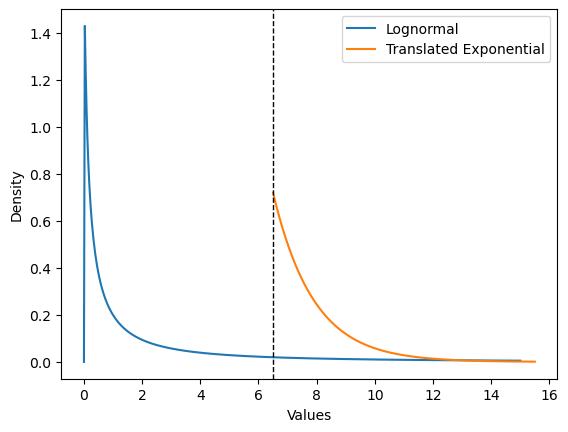

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm, expon

# Parameters
mu = 0
sigma = 2
scale_exp = np.exp(2) - 6
translation = 6.5

# Create a range of values for plotting the PDF
x_range = np.linspace(0, 15, 500)
y_range = np.linspace(translation, translation + 9, 500)

# Calculate the PDFs
# For the lognormal distribution
pdf_lognorm = lognorm.pdf(x_range, s=sigma, scale=np.exp(mu))

# For the translated exponential distribution
pdf_exp = expon.pdf(y_range, loc=translation, scale=scale_exp)

# Plotting the PDFs
#plt.figure(figsize=(7, 4))
plt.plot(x_range, pdf_lognorm, label='Lognormal')
plt.plot(y_range, pdf_exp, label='Translated Exponential')
plt.axvline(x=6.5, color='black', linestyle='--', linewidth = 1)
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
#plt.grid(True)
plt.savefig('two_distributions.eps', format = 'eps')


In [284]:
N_size = 1000
I_size = 3
R = np.zeros((N_size, I_size))

In [411]:
for j in range(I_size):
        R[:,j] = np.random.lognormal(mu[j],sigma[j] , size = N_size)

In [403]:
s_size = int(N_size/2)
R1 = R[0:s_size]
R2 = R[s_size:int(len(R))]    
[w_emp, emp_obj]= portfolio_saa(R1)
l_sample = R2.dot(w_emp)
r = (2*norm.ppf(0.95)*sd(l_sample)/(np.mean(l_sample)-miniance(l_sample)))
eps = 0.0001
delta = r/np.sqrt(len(R))
x_points = af.affine_approx(eps,argmax_kl_dtconj,max_kl_dtconj,delta)
if len(x_points)==2:
    print('true')
[slope, const] = af.makepoints(h_ddro,x_points,delta)

In [342]:
lb = np.zeros(10)
lb2 = np.zeros(len(lb))
SAA = np.zeros(len(lb))
#lb3 = np.zeros(len(lb))
ub = np.zeros(len(lb))
ub_d = np.zeros(len(lb))
sol_dl= []
sol_du = []
sol_p = []
#E_dtrue = np.zeros(len(lb))
#E_ptrue = np.zeros(len(lb))
#E_dmtrue = np.zeros(len(lb))
for i in range(len(lb)):
    R[:,0] = np.random.lognormal(0,2,size = 1000)
    R[:,1] = np.random.lognormal(1.9,0.3,size = 1000)+0.7
    R[:,2] = np.random.lognormal(0,2.1,size = 1000)
    #for j in range(I_size):
        #R[:,j] = np.random.lognormal(mu[j],sigma[j] , size = N_size)
    #R[:,0] = np.random.beta(1.1,2,size = N_size)+(0.5-(1.1)/(1.1+2))
    #R[:,1] = 0.03+np.random.beta(300,300,size = N_size)
    #for j in range(I_size):
    #    R[:,j] = np.random.uniform(mu[j]-dev[j],mu[j]+dev[j], N_size)
    s_size = int(N_size/2)
    #t_b = time.time()
    R1 = R[0:s_size]
    R2 = R[s_size:int(len(R))]    
    [w_emp, emp_obj]= portfolio_saa(R1)
    l_sample = R2.dot(w_emp)
    r = (2*norm.ppf(0.95)*sd(l_sample)/(np.mean(l_sample)-miniance(l_sample)))
    r_l = (2*norm.ppf(0.95)*sd(l_sample)/(miniance(l_sample)))
    eps = 0.0001
    delta = r/np.sqrt(len(R))
    delta_l = r_l/np.sqrt(len(R))
    x_points = af.affine_approx(eps,argmax_kl_dtconj,max_kl_dtconj,delta)
    if len(x_points)==2:
        print('true')
        [w_emp2, emp_obj2] = portfolio_saa(R)
        lb[i] = ((1-np.exp(-delta))/delta *emp_obj2)
    else:
        [slope, const] = af.makepoints(h_ddro,x_points,delta)
        [sol, ub_d[i]] = portfolio_ddro(R,slope,const)
        sol_du.append(sol)
        [slope2, const2] = af.makepoints(h_ddro,x_points,delta_l)
        [sol_l,lb_val] = portfolio_ddro(R,slope2,const2)
        sol_dl.append(sol_l)
        lb[i] = (1-np.exp(-delta_l))/delta_l *lb_val
        #print('dual',sol,'dual_obj', ub_d[i])
        #E_dtrue[i] = (sol_d).dot(mu)
        #E_dmtrue[i] = sol.dot(mu)
    #delta2 = chi2.ppf(0.95,1)/(2*len(R))
    #t_e = time.time()
    #print(t_e-t_b)
    #t_b2 = time.time()
    delta2 = (norm.ppf(0.95)**2)/(2*len(R))
    [sol2,ub_val] = portfolio_dro(R,delta2)
    sol_p.append(sol2)
    #print('primal',sol2,'obj',ub_val)
    #t_e2 = time.time()
    #print(t_e2-t_b2)
    ub[i] = ub_val
    #E_ptrue[i] = sol2.dot(mu)
    [w_emp2, emp_obj2] = portfolio_saa(R)
    SAA[i] = emp_obj2
    #print('SAA', w_emp2)
    l_sample2 = R.dot(w_emp2)
    lb2[i] = entropy_lb(l_sample2,delta2)
    if i % 10 == 0:
        print(i)
    
    

0


In [341]:
mu_true = np.array([np.exp(2), 0.7+np.exp(1.9+0.3**2/2),np.exp(2.1**2/2)])
mu_true

array([7.3890561 , 7.69363186, 9.07025157])

In [55]:
df = pd.read_csv('dual_DRO_data96_tm4d482_new3.csv')

In [56]:
df

,ub_d_20,ub_20,lb_20,lb2_20,SAA_20,ub_d_40,ub_40,lb_40,lb2_40,SAA_40,...,ub_d_1000,ub_1000,lb_1000,lb2_1000,SAA_1000,ub_d_2000,ub_2000,lb_2000,lb2_2000,SAA_2000
0,4.405762,4.400910,2.801783,2.687360,3.505981,5.169969,5.132717,3.201059,3.215589,4.348497,...,4.720960,4.726017,4.184781,4.187427,4.448649,4.812787,4.816539,4.272558,4.292850,4.540102
1,4.933356,4.875789,2.284875,2.349736,3.549853,5.225619,5.263964,2.890723,2.963554,4.014305,...,4.957096,4.964957,4.351376,4.360190,4.650513,4.697811,4.701717,4.289273,4.286212,4.488241
2,5.761475,6.078669,3.246841,2.654715,4.161716,4.770622,4.792155,3.241660,3.088834,3.976861,...,4.688051,4.695658,4.135542,4.128040,4.403131,4.658758,4.661027,4.194156,4.205170,4.420855
3,6.750169,6.856822,4.063067,3.872065,5.371859,4.340975,4.384493,3.004358,2.773765,3.519611,...,4.763704,4.757528,4.224876,4.235069,4.489647,4.814510,4.813720,4.378079,4.379549,4.591289
4,6.394427,6.454995,3.954209,3.612679,4.951714,4.643422,4.653784,3.122445,2.953703,3.760818,...,5.470395,5.403128,4.340839,4.473212,4.905404,4.652580,4.661141,4.257239,4.250724,4.450612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5.040390,5.012889,3.002957,2.310958,3.826784,5.063533,5.110227,3.539941,3.410385,4.334897,...,4.773245,4.739073,4.032237,4.095972,4.394449,4.601965,4.782239,4.226569,4.357800,4.410589
996,4.176857,4.211368,2.369096,2.563745,3.288488,4.391734,4.447660,3.104316,2.919178,3.628979,...,4.873504,4.951780,4.331011,4.276734,4.591761,4.783554,4.649496,4.349046,4.258721,4.564836
997,4.547325,4.502875,2.392835,2.503652,3.609383,4.692269,4.636732,2.547504,2.605419,3.510672,...,4.738050,4.766648,4.183380,4.147419,4.445406,4.649181,4.708707,4.255801,4.269694,4.449685
998,7.035928,6.850169,2.863881,4.044408,5.577487,6.485331,6.460520,4.094398,4.081998,5.329804,...,4.901358,4.906798,4.289486,4.304213,4.594557,4.704897,4.699453,4.273491,4.276919,4.481899


In [40]:
lb_cov = []
lb2_cov = []
ub_cov = []
ub_d_cov = []
m_lb = []
m_lb2 = []
m_ub = []
m_ub_d = []

In [28]:
df_news

,ub_d_20,ub_20,lb_20,lb2_20,ub_d_40,ub_40,lb_40,lb2_40,ub_d_60,ub_60,...,lb_800,lb2_800,ub_d_1000,ub_1000,lb_1000,lb2_1000,ub_d_2000,ub_2000,lb_2000,lb2_2000
0,8.802908,8.819064,5.159130,5.326943,11.242619,11.189721,7.802819,8.522374,10.683290,10.710571,...,9.515068,9.524277,10.853604,10.849703,10.008708,10.022611,10.864146,10.876641,10.264284,10.248808
1,12.809501,12.479384,6.003642,7.433646,12.785824,12.716538,9.538288,9.584107,14.047653,14.363196,...,10.142861,10.125584,10.671672,10.694221,9.884915,9.868241,10.810464,10.824987,10.241747,10.234272
2,16.210423,15.368654,2.634108,5.939367,14.500976,14.695810,8.867201,7.959420,11.373460,11.970486,...,9.785621,9.762398,10.626887,10.677312,9.874971,9.810284,11.167514,11.182496,10.548461,10.549381
3,10.028637,10.052455,6.247650,6.566780,12.228119,12.741630,8.992983,8.704401,11.157517,11.232437,...,9.906680,9.839309,10.589669,10.593078,9.758036,9.781238,10.620579,10.653217,10.073118,10.034765
4,9.773355,9.809773,6.533951,6.086182,10.435242,10.357892,7.489895,7.540735,12.720006,12.788630,...,9.614950,9.613514,11.111865,11.146851,10.339723,10.308342,10.502294,10.506230,9.893312,9.891104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,9.722566,9.755098,6.945938,6.881606,10.365022,10.380624,7.893971,7.972730,14.704318,14.190322,...,10.190907,10.165894,10.966990,10.965333,10.073437,10.086297,10.610239,10.630705,10.056719,10.024214
996,8.536760,8.621150,5.897222,5.613861,13.483491,14.146253,7.141062,7.563865,12.328124,12.185844,...,9.637008,9.813892,10.867265,10.921543,10.089969,10.043637,10.639298,10.654739,10.033837,10.023236
997,9.073492,9.117091,5.794799,5.576578,12.077399,12.092385,8.989708,9.512314,10.618825,10.507303,...,9.908512,9.888311,11.078908,11.080086,10.248304,10.263824,10.829823,10.831982,10.271170,10.257702
998,13.379122,13.467465,9.494092,9.545429,14.876263,16.429472,10.873488,8.739594,11.789008,12.086468,...,9.926280,9.922954,10.696759,10.694952,9.674589,9.711357,10.399313,10.404092,9.832275,9.841282


In [109]:
for i in range(55):
    if i % 5 == 4:
        print(df.columns[i])

SAA_20
SAA_40
SAA_60
SAA_80
SAA_100
SAA_200
SAA_400
SAA_600
SAA_1000
SAA_800
SAA_2000


In [39]:
df_news.columns

Index(['ub_d_20', 'ub_20', 'lb_20', 'lb2_20', 'ub_d_40', 'ub_40', 'lb_40',
       'lb2_40', 'ub_d_60', 'ub_60', 'lb_60', 'lb2_60', 'ub_d_80', 'ub_80',
       'lb_80', 'lb2_80', 'ub_d_100', 'ub_100', 'lb_100', 'lb2_100',
       'ub_d_200', 'ub_200', 'lb_200', 'lb2_200', 'ub_d_400', 'ub_400',
       'lb_400', 'lb2_400', 'ub_d_600', 'ub_600', 'lb_600', 'lb2_600',
       'ub_d_800', 'ub_800', 'lb_800', 'lb2_800', 'ub_d_1000', 'ub_1000',
       'lb_1000', 'lb2_1000', 'ub_d_2000', 'ub_2000', 'lb_2000', 'lb2_2000'],
      dtype='object')

In [41]:
for i in range(44):
    if i % 4 == 0:
        print(df.columns[i])
        ub_d_cov.append(np.sum(df.iloc[:,i]>= obj_true)/1000)
        m_ub_d.append(np.median(df.iloc[:,i]))
    if i % 4 == 1:
        print(df.columns[i])
        ub_cov.append(np.sum(df.iloc[:,i]>= obj_true)/1000)
        m_ub.append(np.median(df.iloc[:,i]))
    if i % 4 == 2:
        print(df.columns[i])
        lb_cov.append(np.sum(df.iloc[:,i]<= obj_true)/1000)
        m_lb.append(np.median(df.iloc[:,i]))
    if i % 4 == 3:
        print(df.columns[i])
        lb2_cov.append(np.sum(df.iloc[:,i]<= obj_true)/1000)
        m_lb2.append(np.median(df.iloc[:,i]))
    
    
        

ub_d_20
ub_20
lb_20
lb2_20
ub_d_40
ub_40
lb_40
lb2_40
ub_d_60
ub_60
lb_60
lb2_60
ub_d_80
ub_80
lb_80
lb2_80
ub_d_100
ub_100
lb_100
lb2_100
ub_d_200
ub_200
lb_200
lb2_200
ub_d_400
ub_400
lb_400
lb2_400
ub_d_600
ub_600
lb_600
lb2_600
ub_d_800
ub_800
lb_800
lb2_800
ub_d_1000
ub_1000
lb_1000
lb2_1000
ub_d_2000
ub_2000
lb_2000
lb2_2000


In [133]:
#lb2_cov[8], lb2_cov[9] = lb2_cov[9], lb2_cov[8]

In [157]:
columns = list(df.columns)

In [42]:
ub_d_cov = np.array(ub_d_cov)
ub_cov = np.array(ub_cov)
lb_cov = np.array(lb_cov)
lb2_cov = np.array(lb2_cov)

In [43]:
ub_d_cov

array([0.751, 0.824, 0.857, 0.874, 0.885, 0.893, 0.919, 0.91 , 0.92 ,
       0.924, 0.956])

In [44]:
data_cov = {'DDRO_ub':ub_d_cov, 'DRO_ub': ub_cov, 'DDRO_lb':lb_cov, 'DRO_lb': lb2_cov}


In [45]:
row_names = ['20', '40', '60', '80', '100', '200', '400', '600', '800', '1000', '2000']
df_cov = pd.DataFrame(data_cov, index = row_names)

In [46]:
df_cov

,DDRO_ub,DRO_ub,DDRO_lb,DRO_lb
20,0.751,0.750,0.974,0.985
40,0.824,0.838,0.962,0.977
60,0.857,0.868,0.965,0.965
80,0.874,0.885,0.956,0.960
100,0.885,0.897,0.956,0.971
200,0.893,0.898,0.952,0.958
400,0.919,0.927,0.957,0.953
600,0.910,0.923,0.963,0.964
800,0.920,0.924,0.963,0.967
1000,0.924,0.932,0.952,0.950


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


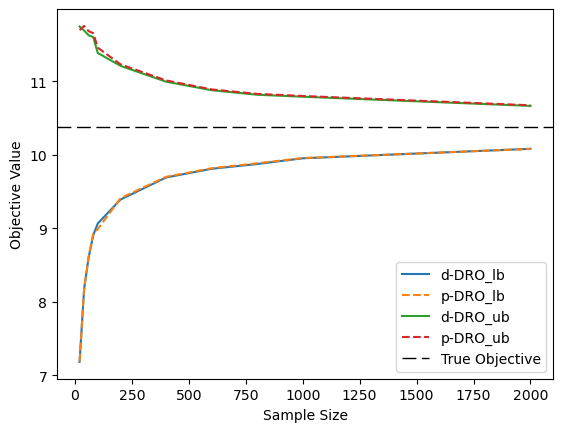

In [48]:
x_as = np.array([20,40,60,80,100,200,400,600,800,1000,2000])

plt.plot(x_as, m_lb, label= 'd-DRO_lb')
plt.plot(x_as, m_lb2, label = 'p-DRO_lb', linestyle = '--')
plt.plot(x_as, m_ub_d, label = 'd-DRO_ub')
plt.plot(x_as, m_ub, label = 'p-DRO_ub', linestyle = '--')
#plt.plot(x_as, m_SAA, label = 'SAA',linestyle='--')
plt.axhline(y=obj_true, color='black',linestyle='--', linewidth = 1,dashes=(10, 4), label= 'True Objective')
plt.xlabel('Sample Size')
plt.ylabel('Objective Value')
plt.legend()
plt.savefig('DDRO_newsvendor.eps', format = 'eps')

In [123]:
print(np.sum(df['ub_800']>=obj_true)/1000)

0.918


In [75]:
df

,ub_d_20,ub_20,lb_20,lb2_20,SAA_20,ub_d_40,ub_40,lb_40,lb2_40,SAA_40,...,ub_d_800,ub_800,lb_800,lb2_800,SAA_800,ub_d_2000,ub_2000,lb_2000,lb2_2000,SAA_2000
0,4.405762,4.400910,2.801783,2.687360,3.505981,5.169969,5.132717,3.201059,3.215589,4.348497,...,4.408336,4.410897,3.887048,3.882179,4.139981,4.812787,4.816539,4.272558,4.292850,4.540102
1,4.933356,4.875789,2.284875,2.349736,3.549853,5.225619,5.263964,2.890723,2.963554,4.014305,...,4.823183,4.844320,4.247709,4.215736,4.518736,4.697811,4.701717,4.289273,4.286212,4.488241
2,5.761475,6.078669,3.246841,2.654715,4.161716,4.770622,4.792155,3.241660,3.088834,3.976861,...,4.565554,4.594732,3.949241,3.944422,4.255234,4.658758,4.661027,4.194156,4.205170,4.420855
3,6.750169,6.856822,4.063067,3.872065,5.371859,4.340975,4.384493,3.004358,2.773765,3.519611,...,4.863908,4.862369,4.198152,4.226558,4.533158,4.814510,4.813720,4.378079,4.379549,4.591289
4,6.394427,6.454995,3.954209,3.612679,4.951714,4.643422,4.653784,3.122445,2.953703,3.760818,...,4.763902,4.767419,4.197338,4.191696,4.470264,4.652580,4.661141,4.257239,4.250724,4.450612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5.040390,5.012889,3.002957,2.310958,3.826784,5.063533,5.110227,3.539941,3.410385,4.334897,...,4.724373,4.716432,4.023487,4.051378,4.369274,4.601965,4.782239,4.226569,4.357800,4.410589
996,4.176857,4.211368,2.369096,2.563745,3.288488,4.391734,4.447660,3.104316,2.919178,3.628979,...,5.118422,5.110907,4.365235,4.395657,4.738964,4.783554,4.649496,4.349046,4.258721,4.564836
997,4.547325,4.502875,2.392835,2.503652,3.609383,4.692269,4.636732,2.547504,2.605419,3.510672,...,5.127566,5.170283,4.438749,4.401012,4.764351,4.649181,4.708707,4.255801,4.269694,4.449685
998,7.035928,6.850169,2.863881,4.044408,5.577487,6.485331,6.460520,4.094398,4.081998,5.329804,...,4.839554,4.879326,4.232559,4.191916,4.517119,4.704897,4.699453,4.273491,4.276919,4.481899


In [419]:
mu_real = np.exp(mu+sigma**2/2)
obj_true = mu_real[0]
print(np.sum(lb<=obj_true)/len(lb))
print(np.sum(lb2<=obj_true)/len(lb2))
print(np.sum(ub>=obj_true)/len(ub))
print(np.sum(ub_d>=obj_true)/len(ub_d))
#print(np.sum((lb2<=obj_true)*(ub>=obj_true))/len(ub))
print(np.median(lb))
print(np.median(lb2))
print(np.median(ub))
print(np.median(ub_d))

0.941
0.951
0.918
0.913
4.157439387068927
4.154184751118464
4.82446764428866
4.8163109440055845


In [120]:
data_news = {'ub_d_20': ub_d, 'ub_20': ub, 'lb_20':lb, 'lb2_20': lb2, 'SAA_20': SAA}
df_news = pd.DataFrame(data_news)

In [121]:
df_news.to_csv('dual_DRO_news.csv', index=False)

In [9]:
df_news = pd.read_csv('dual_DRO_news.csv')

In [10]:
df_news

,ub_d_20,ub_20,lb_20,lb2_20,SAA_20,ub_d_40,ub_40,lb_40,lb2_40,SAA_40,...,ub_d_200,ub_200,lb_200,lb2_200,SAA_200,ub_d_400,ub_400,lb_400,lb2_400,SAA_400
0,17.452959,16.925497,7.511487,9.588367,13.128716,12.366960,12.189837,8.821754,8.661567,10.323634,...,13.408765,13.601292,11.634458,11.498660,12.473204,12.793454,12.796174,11.661675,11.628668,12.202531
1,16.431896,16.583070,10.473869,10.884419,13.770913,13.674291,13.607023,9.322448,10.018542,11.771375,...,12.634189,12.603336,10.817727,10.976055,11.783749,12.847197,12.848862,11.637913,11.687196,12.256583
2,15.742271,15.692395,10.749075,11.483917,13.458837,14.104923,14.812781,10.518944,9.406756,11.829590,...,13.377219,13.361203,11.654359,11.740181,12.534666,12.972238,12.969460,11.665247,11.689273,12.322278
3,17.076704,17.032676,10.588715,10.738106,13.827446,14.722190,14.752837,11.342456,11.263417,12.968556,...,12.813441,12.835445,11.327160,11.275253,12.036570,13.179712,13.174045,12.077184,12.111336,12.639649
4,14.399143,14.404225,10.204401,10.199443,12.316600,15.262692,15.357455,11.704549,11.367666,13.297862,...,13.377544,13.324610,11.533260,11.581515,12.425124,13.015538,13.015346,11.821125,11.839959,12.418557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,10.654998,10.568861,7.632741,7.349497,8.931270,11.807216,11.874151,8.605399,8.469797,10.103419,...,11.485086,11.491250,10.052683,10.094308,10.782594,12.840715,12.852233,11.692165,11.682841,12.260306
96,15.092423,15.126693,10.871605,10.028516,12.674049,12.585582,12.455250,9.814833,9.980928,11.295117,...,12.981689,12.993515,11.390822,11.402707,12.178319,13.153516,13.159121,11.875411,11.923651,12.525505
97,19.111111,19.097185,11.923079,13.328060,16.195147,14.189705,14.368139,10.910272,10.627606,12.411987,...,13.079480,13.095423,11.473871,11.485135,12.285743,13.221476,13.231324,11.850718,11.878734,12.537322
98,15.328329,15.720653,10.225124,10.208297,12.798870,14.882078,15.312977,10.901406,10.961155,12.918616,...,12.692293,12.726297,11.225331,11.154759,11.931127,12.963098,12.959812,11.780950,11.772028,12.360509


In [11]:
df_news.columns.tolist()

['ub_d_20',
 'ub_20',
 'lb_20',
 'lb2_20',
 'SAA_20',
 'ub_d_40',
 'ub_40',
 'lb_40',
 'lb2_40',
 'SAA_40',
 'ub_d_60',
 'ub_60',
 'lb_60',
 'lb2_60',
 'SAA_60',
 'ub_d_80',
 'ub_80',
 'lb_80',
 'lb2_80',
 'SAA_80',
 'ub_d_100',
 'ub_100',
 'lb_100',
 'lb2_100',
 'SAA_100',
 'ub_d_200',
 'ub_200',
 'lb_200',
 'lb2_200',
 'SAA_200',
 'ub_d_400',
 'ub_400',
 'lb_400',
 'lb2_400',
 'SAA_400']

In [90]:
[w_true, obj_true] = portfolio_true(mu)
print(w_true,obj_true)

[1.00000000e+00 1.26707895e-13 2.21515062e-12 1.49704863e-12
 1.06404844e-12] 10.00000000000546


In [237]:
print(np.sum(lb<=obj_true)/len(lb))
print(np.sum(lb2<=obj_true)/len(lb2))
print(np.sum(ub>=obj_true)/len(ub))
print(np.sum(SAA<=obj_true)/len(ub))
#print(np.sum((lb2<=obj_true)*(ub>=obj_true))/len(ub))
print(np.mean(lb))
print(np.mean(lb2))

1.0
1.0
0.6
0.4
0.9844143190603735
0.9841484124029861


In [21]:
#data2 = {'lb_200': lb, 'lb2_200': lb2, 'ub_200':ub, 'SAA_200': SAA}
#df2 = pd.DataFrame(data2)


In [86]:
df2['lb_1000'] = lb
df2['lb2_1000'] = lb2
df2['ub_1000'] = ub
df2['SAA_1000'] = SAA

In [151]:
df2

,lb_100,lb2_100,ub_100,SAA_100,lb_200,lb2_200,ub_200,SAA_200,lb_300,lb2_300,...,ub_600,SAA_600,lb_800,lb2_800,ub_800,SAA_800,lb_1000,lb2_1000,ub_1000,SAA_1000
0,-2.301127,-2.301343,-2.092404,-2.111501,-2.315150,-2.314525,-2.148560,-2.159540,-2.194360,-2.193560,...,-2.135169,-2.138772,-2.338570,-2.331315,-2.164835,-2.175826,-2.219054,-2.215924,-2.146822,-2.148942
1,-2.328646,-2.308156,-2.082692,-2.103219,-2.359315,-2.361231,-2.200562,-2.211188,-2.279076,-2.273458,...,-2.054308,-2.057844,-2.274287,-2.278773,-2.111400,-2.122457,-2.167231,-2.166535,-2.095358,-2.098735
2,-2.254906,-2.249857,-2.027588,-2.044949,-2.254061,-2.248118,-2.096547,-2.106596,-2.361685,-2.360988,...,-2.109436,-2.112973,-2.229006,-2.235536,-2.070559,-2.081469,-2.138942,-2.138304,-2.067452,-2.069627
3,-2.531292,-2.497931,-2.268698,-2.289407,-2.210918,-2.211487,-2.057890,-2.068067,-2.201948,-2.209237,...,-2.130686,-2.134184,-2.313775,-2.316327,-2.145671,-2.156965,-2.169141,-2.167607,-2.099389,-2.102267
4,-2.553947,-2.568693,-2.352857,-2.372462,-2.307655,-2.300438,-2.140677,-2.151253,-2.095997,-2.103666,...,-2.120386,-2.124361,-2.230891,-2.232626,-2.072870,-2.083451,-2.213793,-2.213727,-2.143973,-2.146112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-2.525485,-2.521096,-2.311127,-2.330082,-2.096331,-2.108650,-1.955260,-1.965408,-2.151718,-2.152049,...,-2.112033,-2.115340,-2.224432,-2.221815,-2.070212,-2.080230,-2.244413,-2.241635,-2.173368,-2.175472
996,-2.295706,-2.303135,-2.072475,-2.093516,-2.348145,-2.350298,-2.201662,-2.211503,-2.184204,-2.170837,...,-2.130865,-2.134567,-2.228290,-2.207598,-2.058338,-2.068179,-2.152801,-2.150316,-2.079422,-2.082981
997,-2.258199,-2.279073,-2.034301,-2.056614,-2.284414,-2.282563,-2.115133,-2.126189,-2.259902,-2.251570,...,-2.064083,-2.067700,-2.351686,-2.376707,-2.206566,-2.217794,-2.181551,-2.179480,-2.110616,-2.112732
998,-2.337623,-2.349412,-2.138092,-2.157336,-2.282565,-2.286797,-2.123519,-2.134326,-2.155944,-2.137932,...,-2.147459,-2.151221,-2.261076,-2.260113,-2.100313,-2.110908,-2.290466,-2.287824,-2.218300,-2.220437


In [150]:
df2.to_csv('dual_DRO_data3.csv', index=False)

In [149]:
#df2['lb_2000'][700:800] = lb
#df2['lb2_2000'][700:800] = lb2
#df2['ub_2000'][700:800] = ub
#df2['SAA_2000'][700:800] = SAA

In [148]:
df2['lb_2000'][699]

-2.1112386367796674

In [211]:
eps = 0.001
delta = r/np.sqrt(3000)
x_points = af.affine_approx(eps,argmax_kl_dtconj,max_kl_dtconj,delta)
[slope, const] = af.makepoints(h_ddro,x_points,delta)

In [84]:
lb = np.zeros(1000)
lb2 = np.zeros(len(lb))
#lb3 = np.zeros(len(lb))
ub = np.zeros(len(lb))
for i in range(len(lb)):
    R0 = np.random.multivariate_normal(mu_1,sigma,size = 300)
    R = np.exp(1/np.sqrt(np.diag(sigma))*R0)
    s_size = int(len(R)/2)
    R1 = R[0:s_size]
    R2 = R[s_size:int(len(R))]    
    [w_emp, emp_obj]= portfolio_saa(R1)
    l_sample = R2.dot(w_emp)
    r = (2*norm.ppf(0.95)*sd(l_sample)/miniance(l_sample))
    eps = 0.001
    delta = r/np.sqrt(len(R))
    x_points = af.affine_approx(eps,argmax_kl_dtconj,max_kl_dtconj,delta)
    [slope, const] = af.makepoints(h_ddro,x_points,delta)
    [sol, lb_val] = portfolio_ddro(R,slope,const)
    lb[i] = (1-np.exp(-delta))/delta *lb_val
    delta2 = (norm.ppf(0.95)**2)/(2*len(R))
    [sol2,ub_val] = portfolio_dro(R,delta2)
    ub[i] = ub_val
    [w_emp2, emp_obj2] = portfolio_saa(R)
    l_sample2 = R.dot(w_emp2)
    lb2[i] = entropy_lb(l_sample2,delta2)
    if i % 10 == 0:
        print(i)
    
    

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [85]:
print(np.sum(lb<=obj_true)/len(lb))
print(np.sum(ub>=obj_true)/len(ub))
print(np.sum(lb2<=obj_true)/len(lb2))

1.0
0.393
0.999


In [90]:
df['ub_N300'] = ub

In [91]:
df

,lb_N100,lb2_N100,ub_N100,lb_N200,lb2_N200,ub_N200,lb_N300,lb2_N300,ub_N300
0,1.047972,1.036342,1.234451,1.358227,1.310849,1.482095,1.508807,1.508635,1.681826
1,1.137124,1.227199,1.487948,1.101084,1.091627,1.245730,1.389144,1.358118,1.547037
2,1.109838,1.117335,1.341766,1.371958,1.363882,1.539289,1.390630,1.368911,1.527851
3,1.375945,1.370195,1.700473,1.335025,1.388512,1.619461,1.315513,1.384329,1.576327
4,1.249592,1.253874,1.455463,1.208083,1.181345,1.360241,1.418038,1.432170,1.597332
...,...,...,...,...,...,...,...,...,...
995,1.218093,1.263401,1.539120,1.335902,1.520352,1.771088,1.437864,1.462348,1.651733
996,1.315584,1.352330,1.703298,1.277847,1.367544,1.543393,1.459114,1.460571,1.622964
997,1.147373,1.148567,1.360893,1.391853,1.328964,1.592938,1.446328,1.452477,1.640092
998,1.201129,1.245780,1.555203,1.359482,1.362097,1.552127,1.474991,1.419699,1.637521


In [92]:
df.to_csv('dual_DRO_data.csv', index=False)

In [173]:
[w_true, obj_true] = portfolio_true(mu)
print(w_true,obj_true)

[0. 0. 1. 0. 0.] 1.6487743629284042


In [84]:
[w_emp, emp_obj]= portfolio_saa(R1)
l_sample = R1.dot(w_true)
r = (2*norm.ppf(0.95)*sd(l_sample)/miniance(l_sample))

In [125]:
[sol, lb_val] = portfolio_ddro(R,slope,const)
print(sol)
print((1-np.exp(-delta))/delta *lb_val)

[4.32843168e-12 6.98155739e-14 5.63231156e-01 1.24182546e-12
 4.36768844e-01]
1.5542302273405537


In [171]:
Y = np.zeros(1000)
for i in range(np.size(Y)):
    Y[i]=np.random.binomial(1,0.3)
miniance(Y)

0.10048900000000001

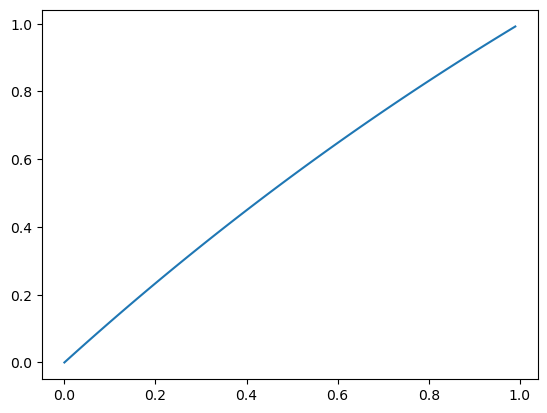

In [122]:
x_as = np.arange(0,1,1/100)
y_as = h_ddro(x_as,delta)
plt.plot(x_as,y_as)
#y_2 = h_ddro(x_points,delta)
#plt.plot(x_points,y_2,color = 'red')